# Review Classification

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

In [6]:
df_reviews.info(memory_usage='deep')

We can see there are two columns (`average_rating` and `votes`) that are missing 2 values. As the goal is to detect negative reviews, we will base our model only on the reviews themselves and not on other features that might cause a data leakage. Thus we won't deal with these missing values.

In [7]:
df_reviews.describe()

In [8]:
df_reviews.describe(include = [np.object])

We can see there are some reviews that are not unique, we want to remove those rows where all the info (except the idx) are duplicated.

In [9]:
df_reviews.drop(['idx'], axis=1).duplicated().sum()

In [10]:
# remove the rows with the duplicated reviews
df_reviews.drop(index = df_reviews[df_reviews.drop(['idx'], axis=1).duplicated()].index, inplace = True)

## EDA

Let's check the number of movies and reviews over years.

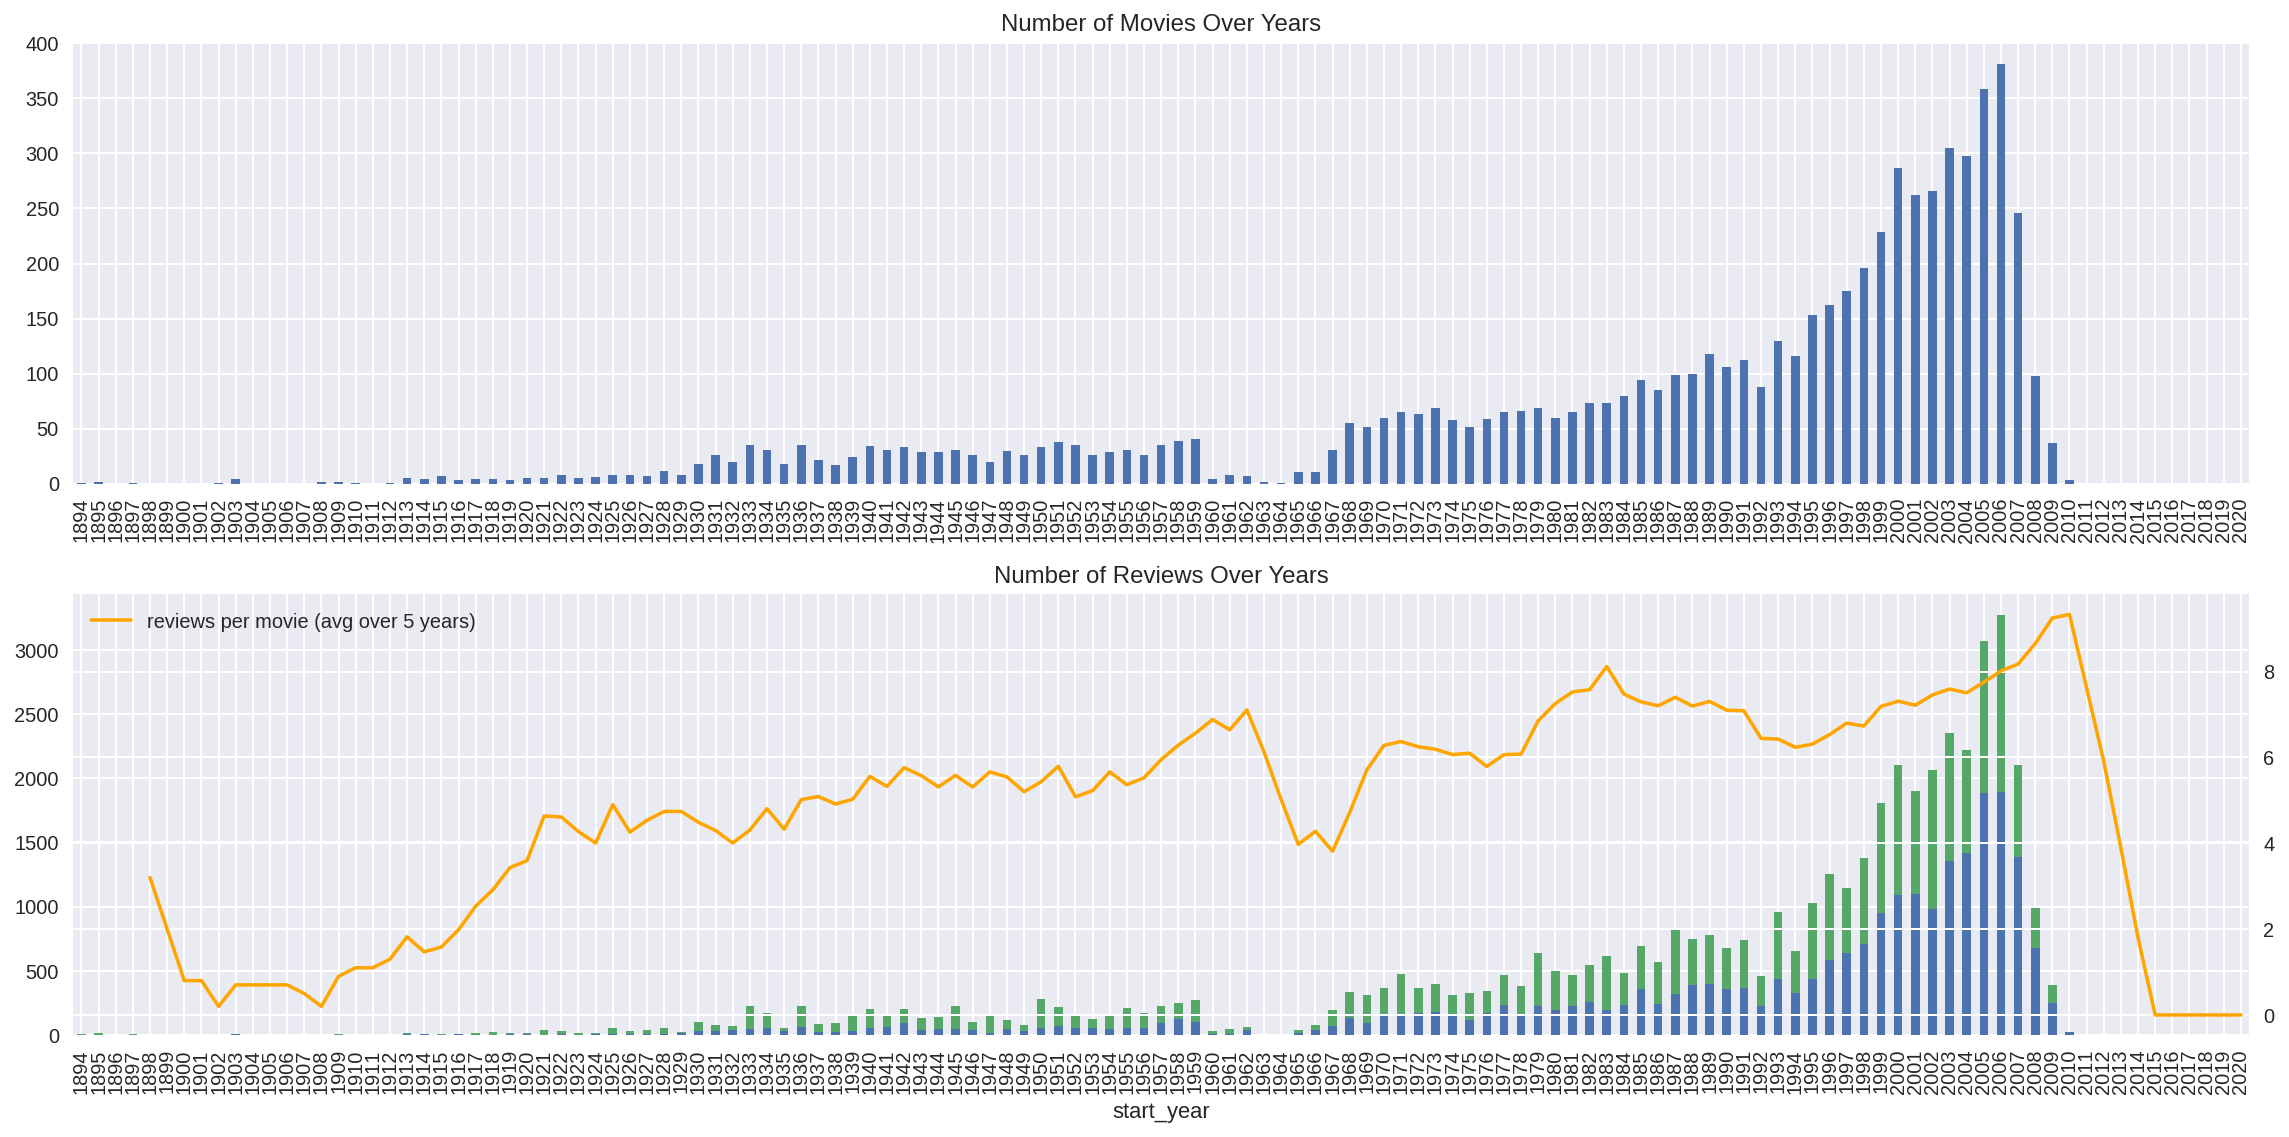

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

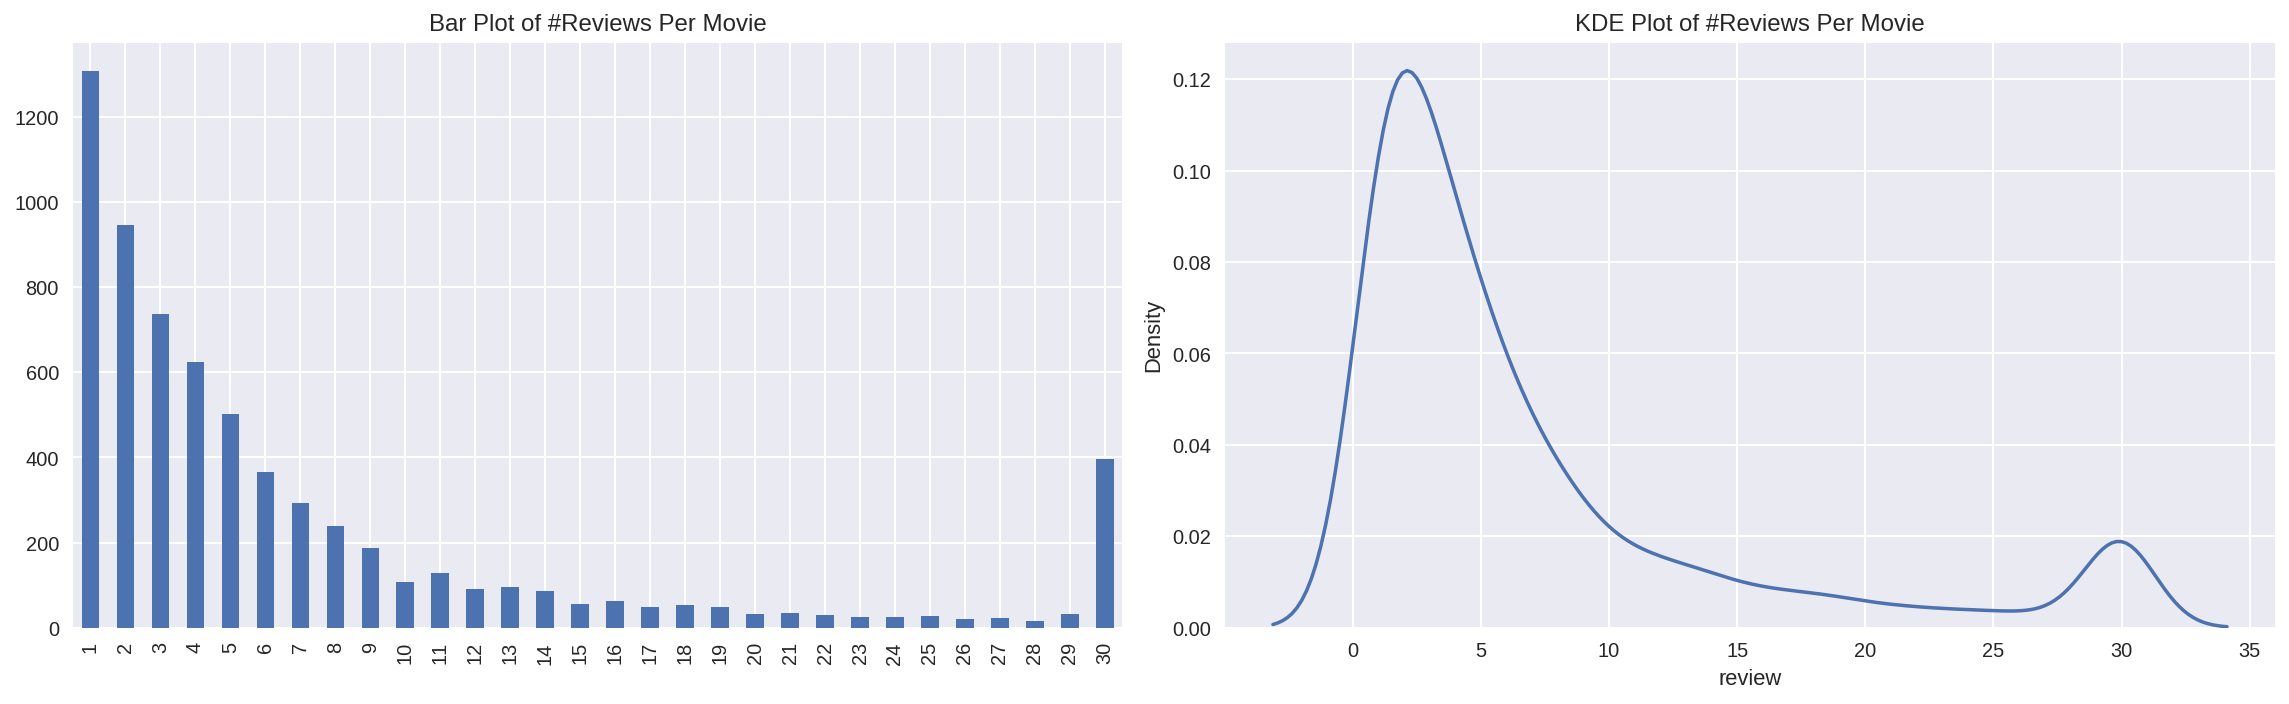

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Most of the movies have few reviews and only a small chunck has more than 10 reviews. Though there's a noticeable amount of movies that have 30 reviews.
Mow we want to see the balance in our target variable.

In [13]:
# check if the target is balanced
df_reviews['pos'].value_counts()

Now we'll check if this balance is kept in the train set.

In [14]:
# check if the target is balanced in the train set
df_reviews.query('ds_part == "train"')['pos'].value_counts()

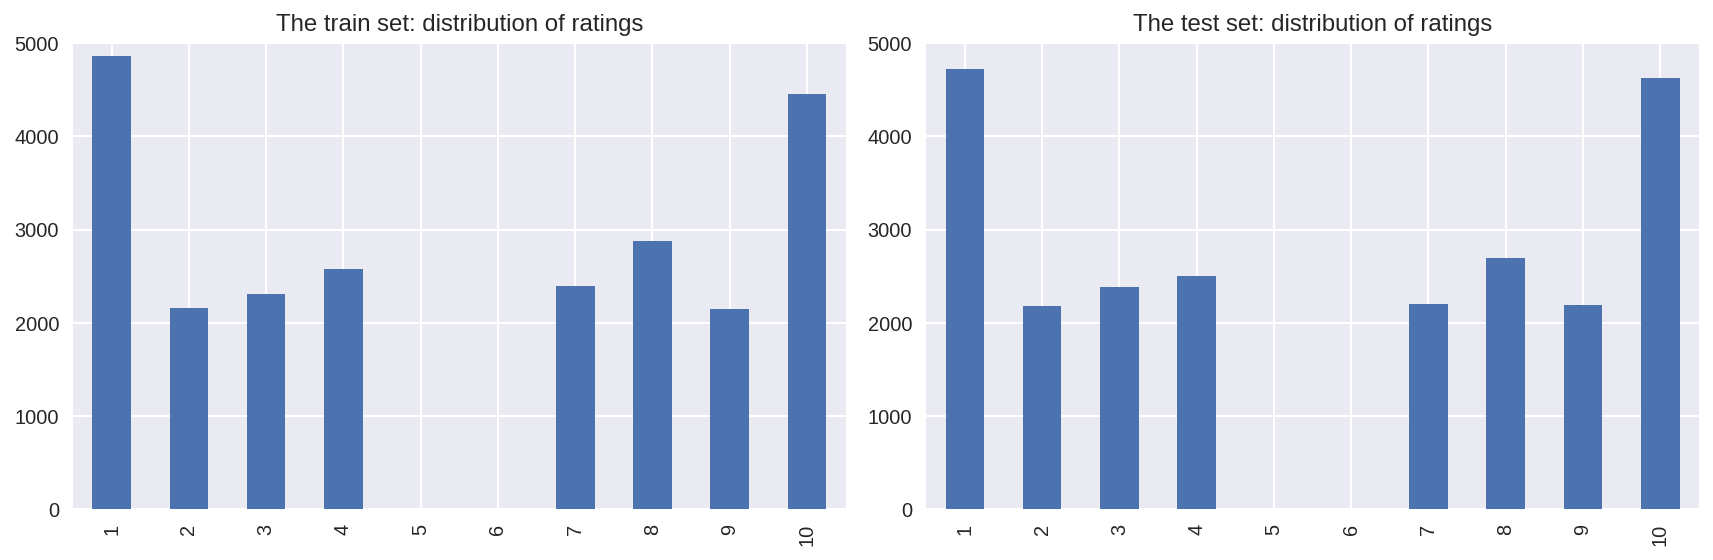

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Most of the reviewers have a strong opinion, or thay really liked it, or they very much disliked it.

Distribution of negative and positive reviews over the years for two parts of the dataset

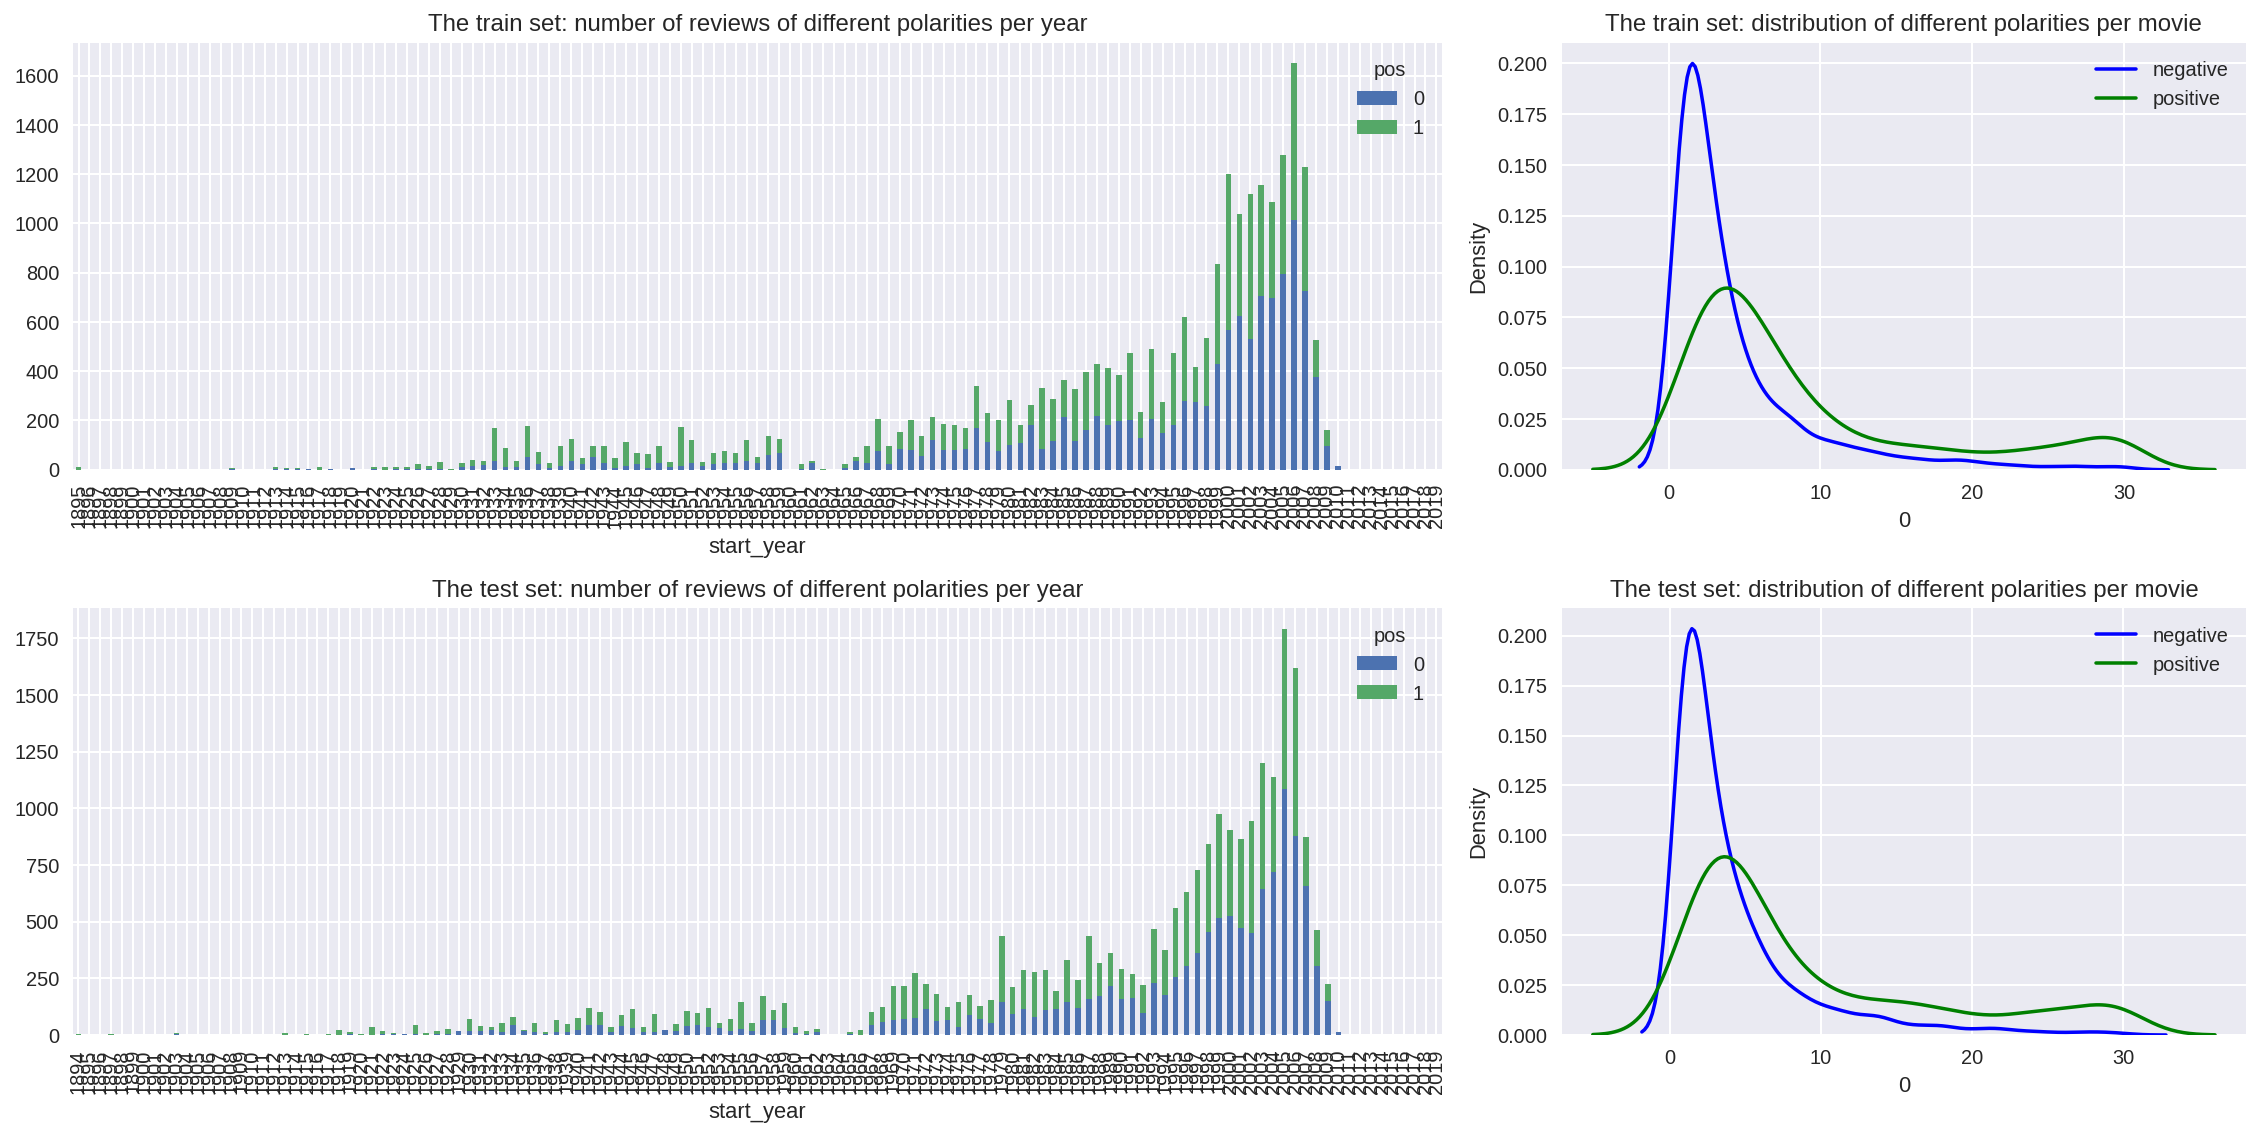

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

We see that the distributions in the training set are very similar to those of the testing set.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [17]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [18]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: " ".join(re.sub(r'[^a-zA-Z\']', ' ', x.lower()).split()))

In [19]:
df_reviews.loc[1,'review']

In [20]:
df_reviews.loc[1,'review_norm']

The normalization seems to work as expected!

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [21]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

## Working with models

### Model 0 - Constant

In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
train_features_0 = df_reviews_train['review_norm']
test_features_0 = df_reviews_test['review_norm']

In [24]:
model_0 = DummyClassifier(strategy= 'stratified', random_state = 123)

In [25]:
%%time
model_0.fit(train_features_0, train_target)

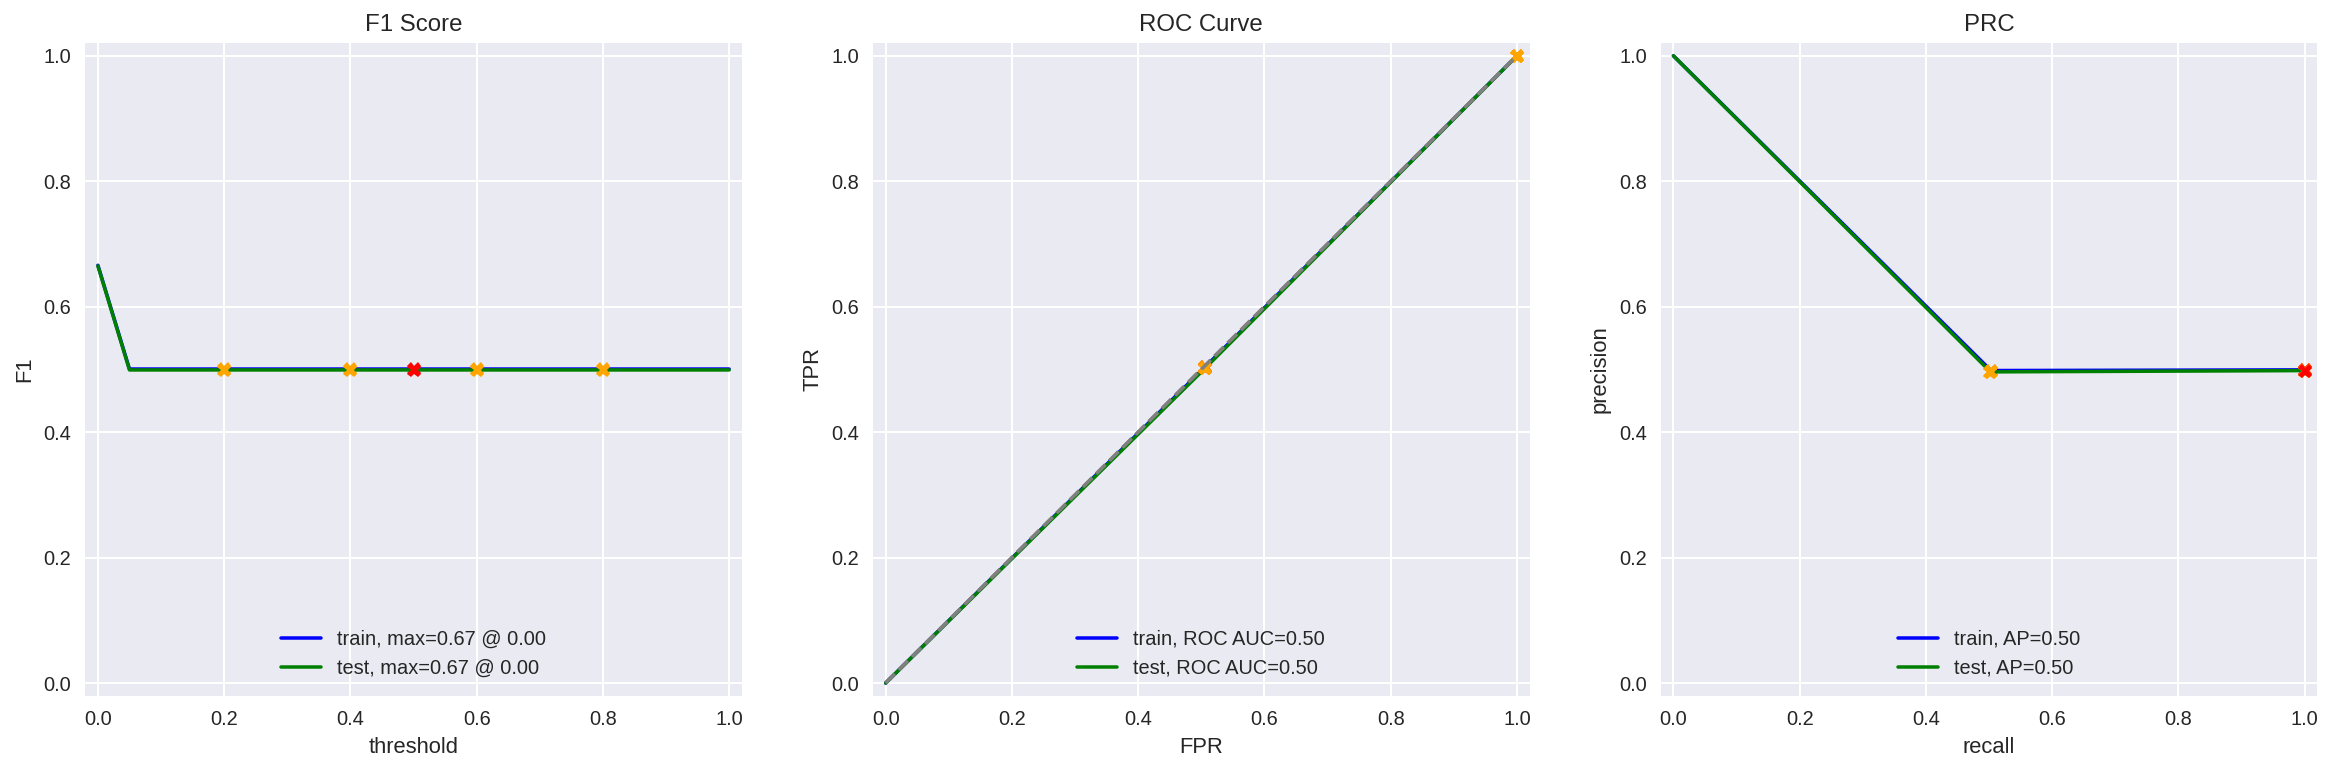

In [26]:
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

Because the target is balanced, the dummy modle is just like guessing - has a chance of 50% to be correct.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [27]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline

In [30]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

In [31]:
def text_preprocessing_1(text):
    tokens = word_tokenize(text)
    lemmas = [WordNetLemmatizer().lemmatize(token) for token in tokens]
    
    return " ".join(lemmas)

In [32]:
%%time
corpus_train_1 = df_reviews_train['review_norm'].apply(text_preprocessing_1)
corpus_test_1 = df_reviews_test['review_norm'].apply(text_preprocessing_1)

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
stop_words = set(stopwords.words('english'))

# creating a pipeline
pipe1 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LogisticRegression(random_state = 123))]
)

param_grid = {'clf__C': [0.1, 1, 10, 100]}
grid1 = GridSearchCV(pipe1, param_grid, cv=3, scoring = "f1")

grid1.fit(corpus_train_1, train_target)

print("Best params:")
print(grid1.best_params_)

print(f"Best F1 score: {abs(grid1.best_score_):.3f}")

In [35]:
%%time
pipe1 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LogisticRegression(C = 1, random_state = 123))]
)

pipe1.fit(corpus_train_1, train_target)

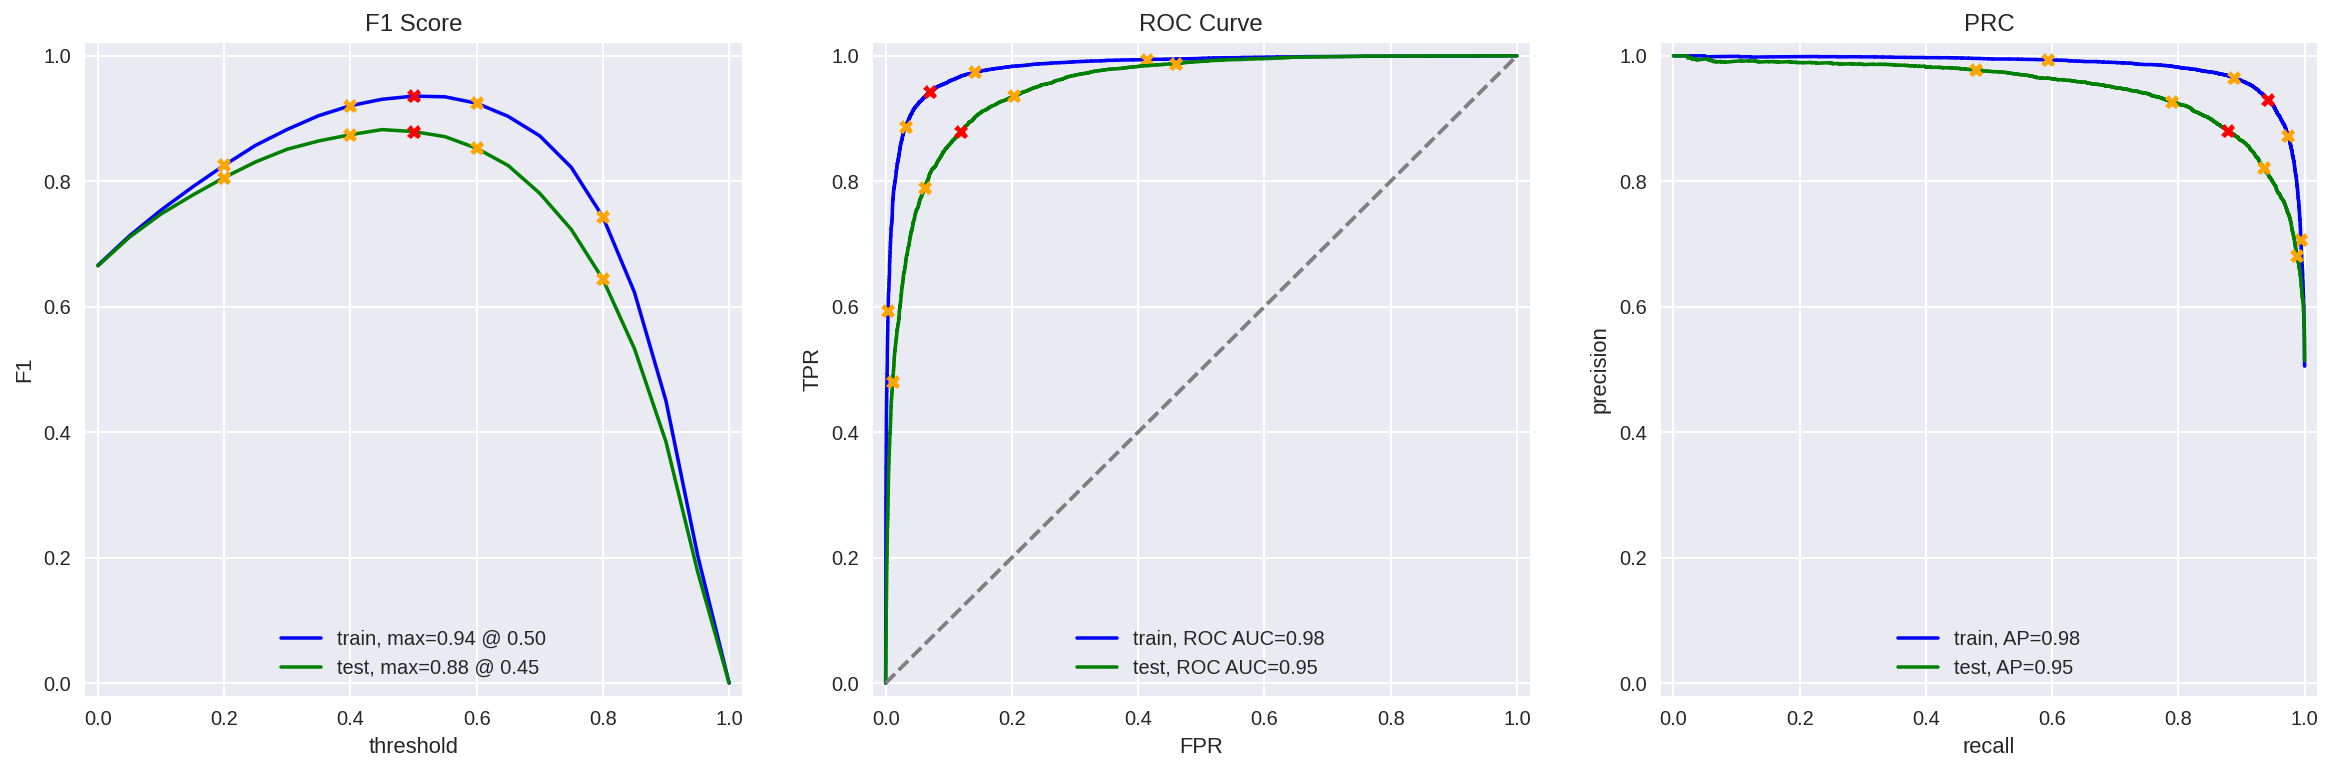

In [36]:
evaluate_model(pipe1, corpus_train_1, train_target, corpus_test_1, test_target)

We got F1 score of 0.94 for the training set and 0.88 for the test set, which is above our threshold (F1 score of at least 0.85). The text feature processing took 1min 31s. The model fitting took 2.11 s.

### Model 3 - spaCy, TF-IDF and LR

In [ ]:
#!pip install -U spacy
#!python -m spacy download en

In [37]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [38]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [39]:
%%time
corpus_train_3 = df_reviews_train['review_norm'].apply(text_preprocessing_3)
corpus_test_3 = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [40]:
# creating a pipeline
pipe3 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LogisticRegression(random_state = 123))]
)

param_grid = {'clf__C': [0.1, 1, 10, 100]}
grid3 = GridSearchCV(pipe3, param_grid, cv=3, scoring = "f1")

grid3.fit(corpus_train_3, train_target)

print("Best params:")
print(grid3.best_params_)

print(f"Best F1 score: {abs(grid3.best_score_):.3f}")

In [41]:
%%time
pipe3 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LogisticRegression(C = 1, random_state = 123))]
)

pipe3.fit(corpus_train_3, train_target)

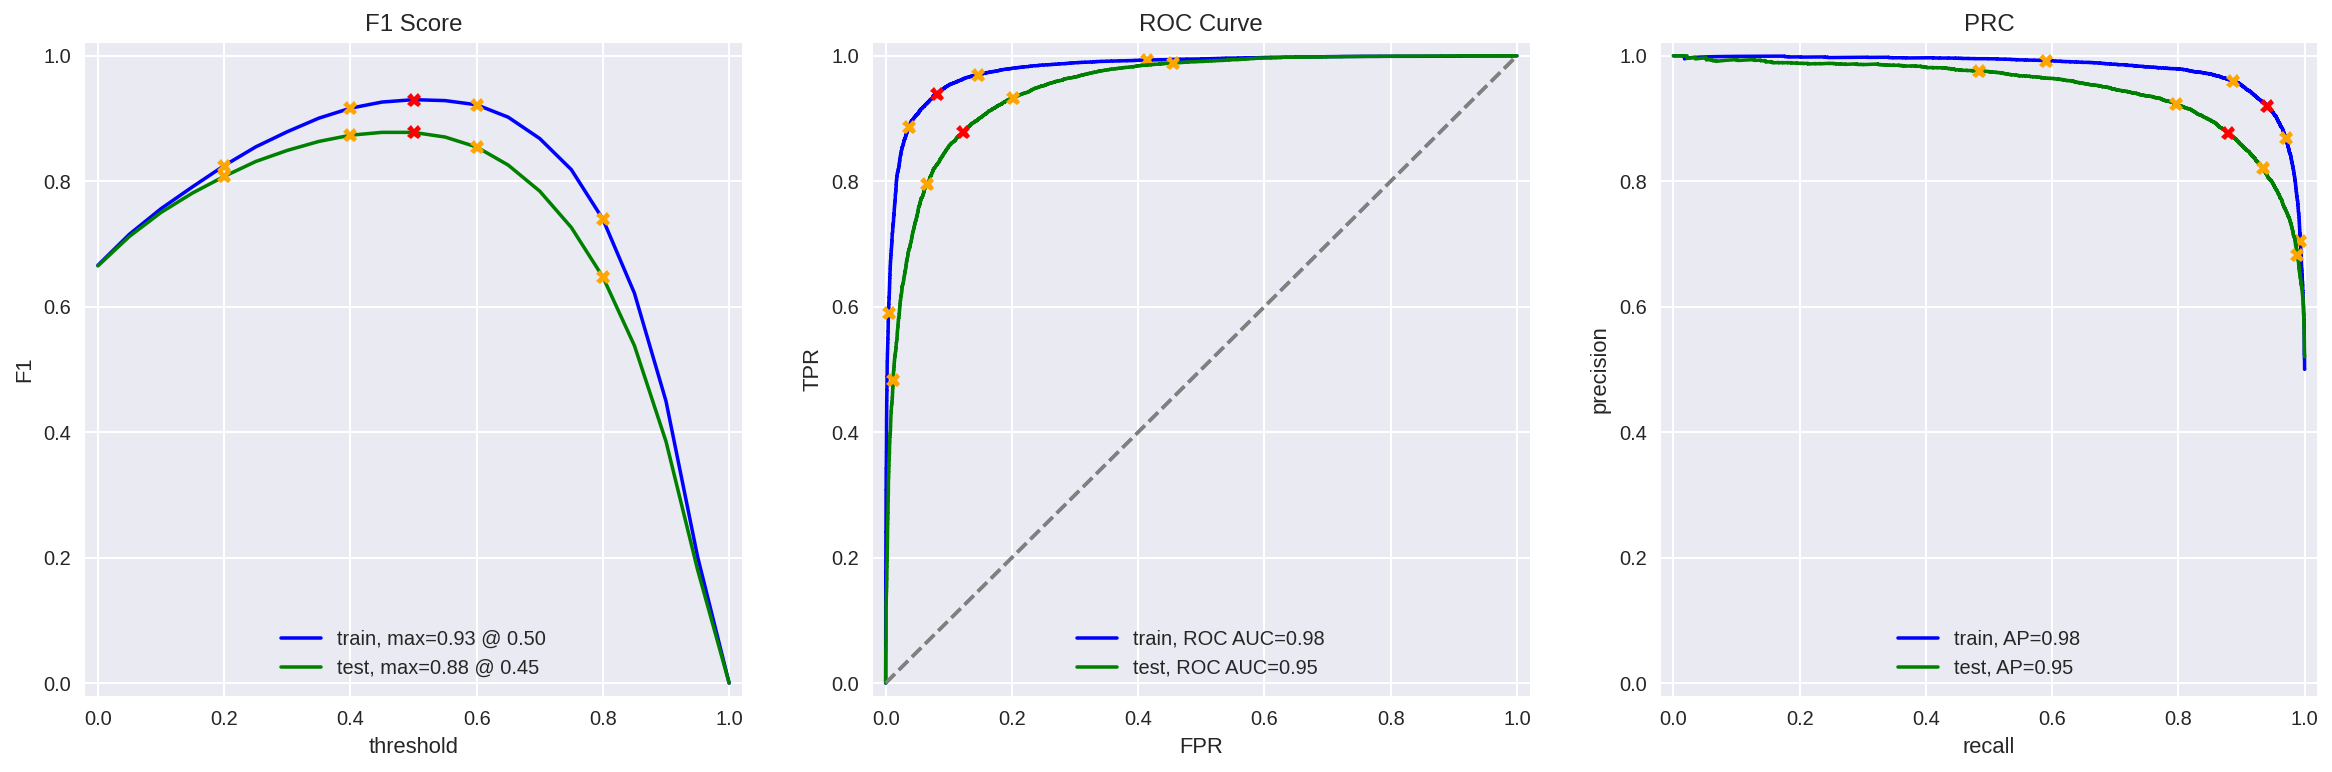

In [42]:
evaluate_model(pipe3, corpus_train_3, train_target, corpus_test_3, test_target)

We got F1 score of 0.93 for the training set and 0.88 for the test set, which is above our threshold. The text feature processing took 8min 5s. The model fitting took 2.58 s.
For now, the best choice is the pre-processing of model 1.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
#!pip install lightgbm

In [43]:
from lightgbm import LGBMClassifier

In [44]:
# creating a pipeline
pipe4 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LGBMClassifier(random_state = 123))])

param_grid = {
    "clf__learning_rate" : [0.1, 0.2, 0.3],
    "clf__n_estimators" : [150, 200],
    "clf__max_depth" : [10, 20]
}
grid4 = GridSearchCV(pipe4, param_grid, cv=3, scoring = "f1")

grid4.fit(corpus_train_3, train_target)

print("Best params:")
print(grid4.best_params_)

print(f"Best F1 score: {abs(grid4.best_score_):.3f}")

In [45]:
%%time
pipe4 = Pipeline(
    steps=[("tfidf", TfidfVectorizer(stop_words=stop_words)), 
           ("clf", LGBMClassifier(learning_rate = 0.2, n_estimators = 200, 
                                  max_depth = 20, random_state = 123))]
)

pipe4.fit(corpus_train_3, train_target)

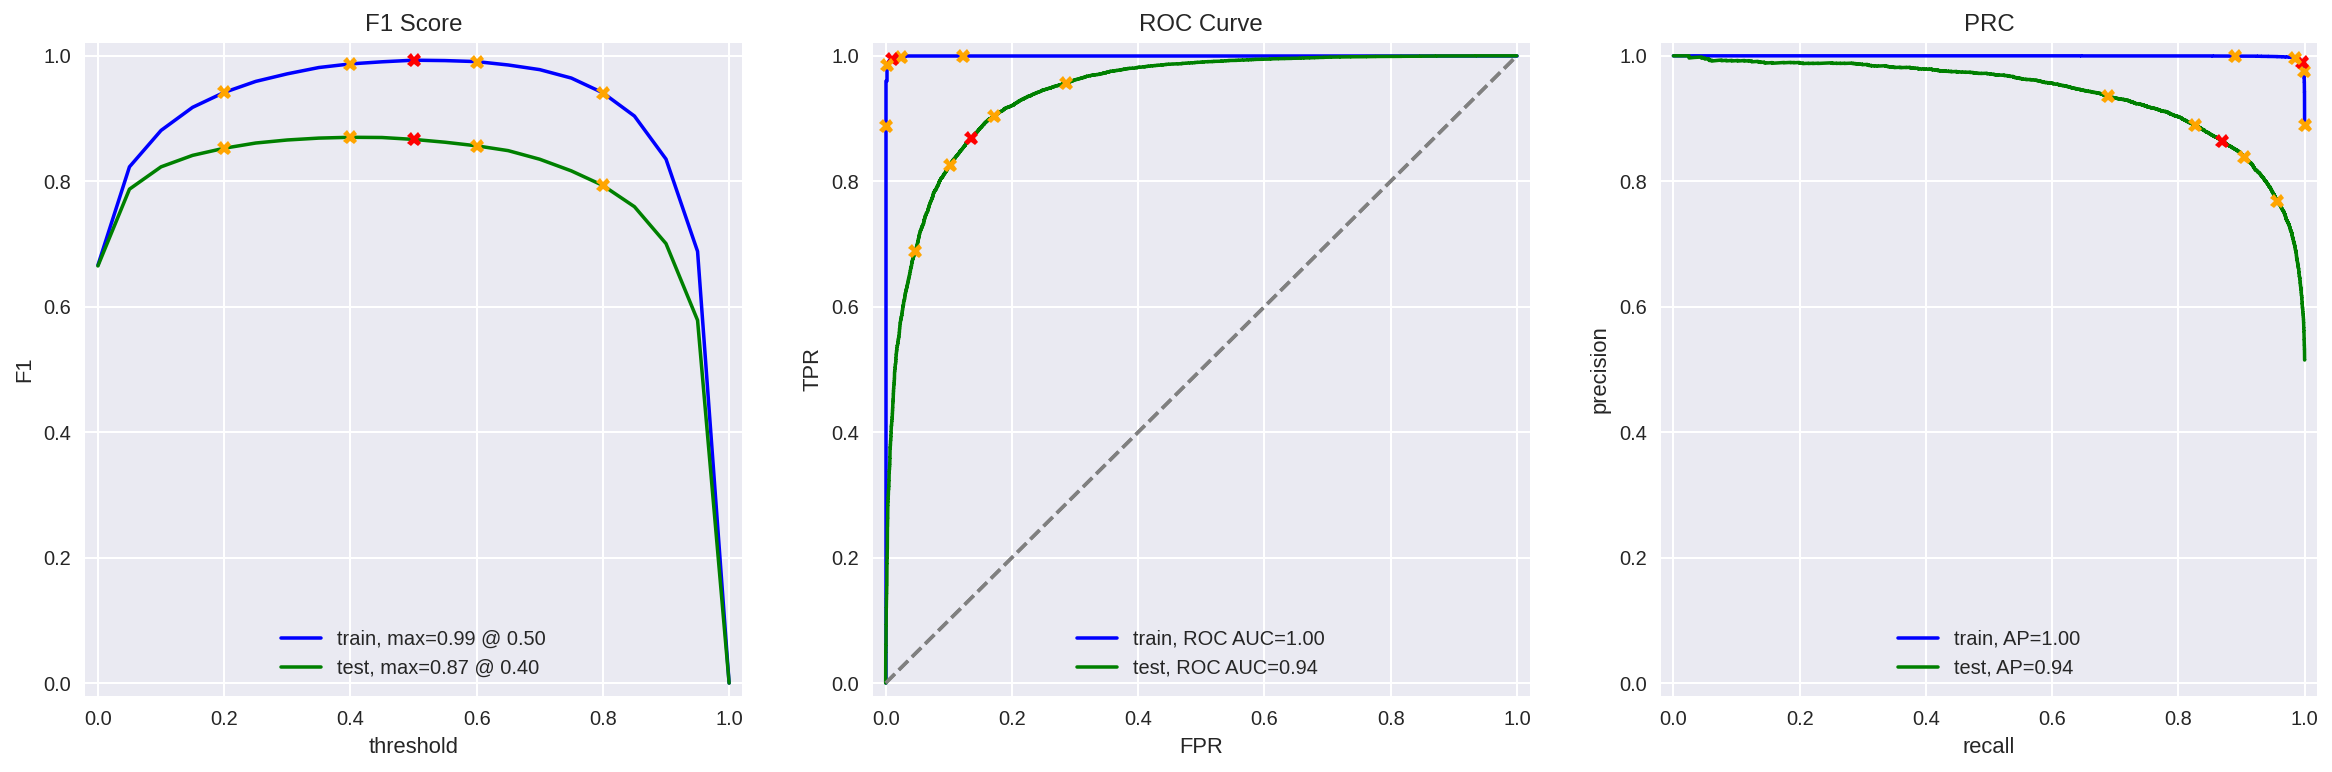

In [46]:
evaluate_model(pipe4, corpus_train_3, train_target, corpus_test_3, test_target)

We got F1 score of 0.99 for the training set and 0.87 for the test set, which is above our threshold. The text feature processing is the same as for model 3 (8min 5s). The model fitting took 1min 17s. Though the results for the training set are the best so far, we are interested in the results of the training set, thus the best choice is is still model 1.

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    for input_text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
%time
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

In [ ]:
# load
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [ ]:
model_9 = LogisticRegression(random_state = 123)
param_grid = {'C': [0.1, 1, 10, 100]}
grid9 = GridSearchCV(model_9, param_grid, cv=3, scoring = "f1")

grid9.fit(train_features_9, train_target)

print("Best params:")
print(grid9.best_params_)

print(f"Best F1 score: {abs(grid9.best_score_):.3f}")

In [ ]:
%%time
model_9 = LogisticRegression(C = 0.1, random_state = 123)
model_9.fit(train_features_9, train_target)

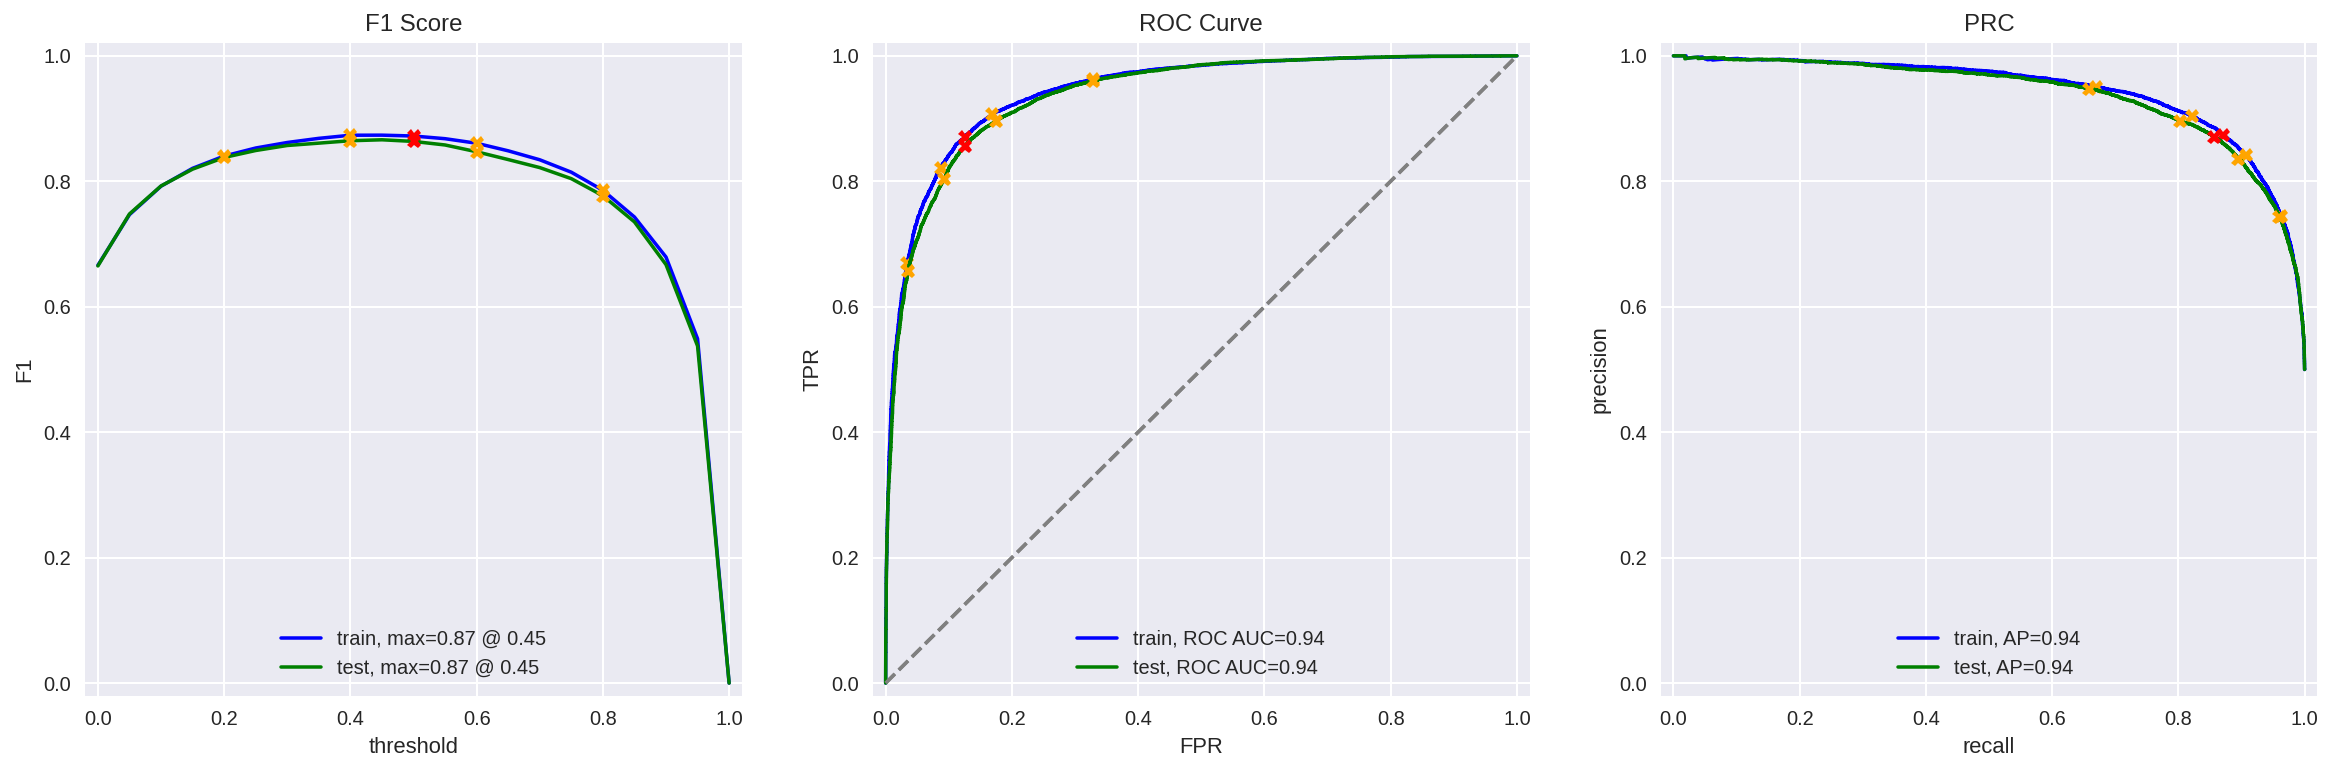

In [ ]:
evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

We got F1 score of 0.87 for the training set and 0.86 for the test set, which is above our threshold. The text feature processing was longer than is shown and took about 55 min. The model fitting took 3.03 s. We can see that the results show that there's no overfiting in this model, almost exact results for the training a test set.

## My Reviews

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: " ".join(re.sub(r'[^a-zA-Z\']', ' ', x.lower()).split()))
my_reviews

### Model 1

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts.apply(lambda x: text_preprocessing_1(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 4

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

Using NLTK, TF-IDF and LR gave us the best results in term of F1 score, compared to all the other preprocessing and models. In the "My Reviews" part we can see that for all the methods except BERT, the review "I was really fascinated with the movie" which is considered unequivocally positive, get probability of about 0.5 and for model 4 the review "i did not simply like it not my kind of movie" which is negative got probability of 0.64. In this term the best preprocessing was BERT but maybe the chosen model was not good enough.